# Convolution Explained Using MNIST Data

## Downlaod Data

In [1]:
%matplotlib inline
import math,sys,os,numpy as np
import pandas as pd
from numpy.linalg import norm
from PIL import Image
from matplotlib import pyplot as plt, rcParams, rc
from scipy.ndimage import imread
from skimage.measure import block_reduce
import six.moves.cPickle as pickle
from scipy.ndimage.filters import correlate, convolve
from ipywidgets import interact, interactive, fixed
from ipywidgets.widgets import *
rc('animation', html='html5')
rcParams['figure.figsize'] = 3, 6
%precision 4
np.set_printoptions(precision=4, linewidth=100)

In [2]:
WORK_DIR = '/Users/PeiYingchi/Documents/fastai-notes/deeplearning1/nbs'
DATA_DIR = WORK_DIR + '/data/'

In [3]:
def plots(ims, interp=False, titles=None):
    ims=np.array(ims)
    mn,mx=ims.min(),ims.max()
    f = plt.figure(figsize=(12,24))
    for i in range(len(ims)):
        sp=f.add_subplot(1, len(ims), i+1)
        if not titles is None: sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none', vmin=mn,vmax=mx)

def plot(im, interp=False):
    f = plt.figure(figsize=(3,6), frameon=True)
    plt.imshow(im, interpolation=None if interp else 'none')

plt.gray()
plt.close()

Now, we have 2 choices for downloading the MNIST data

1. Download from Kaggle `kg download -c digit-recognizer` ==> `train.csv` `test.csv` 
2. Download using code from [tensorlow mnist tutorial](https://www.tensorflow.org/get_started/mnist/beginners) ==> `train.npz`

I have tried both methods. The data downloaded are slightly different, i.e. the number of rows are different. 

### Data From Kaggle - ETL Needed

In [38]:
df = pd.read_csv(DATA_DIR+'MNIST_kg/train.csv')
print(data.shape)

(42000, 785)


In [24]:
arr_2d = np.arange(24).reshape(2,-1)
print(arr_2d)
arr_3d = arr_2d.reshape(2,3,4,order='C')
print(arr_3d)

[[ 0  1  2  3  4  5  6  7  8  9 10 11]
 [12 13 14 15 16 17 18 19 20 21 22 23]]
[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]]


In [34]:
labels=df['label'].as_matrix()
df_images = df.drop('label', axis=1)
images = df_images.as_matrix()

images = images.reshape(len(labels), 28, 28)
np.savez_compressed(DATA_DIR+'MNIST_kg/'+'train.npz', labels=labels, images=images)

### Data From Tensorflow Tutorial

In [43]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/')
images, labels = mnist.train.images, mnist.train.labels
images = images.reshape((55000,28,28))
np.savez_compressed(DATA_DIR+'MNIST_tf/train.npz', images=images, labels=labels)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Read In Saved Data

In [4]:
# data = np.load(DATA_DIR+'MNIST_data/train.npz')
data = np.load(DATA_DIR+'MNIST_tf/train.npz')
print(data.keys())
labels = data['labels']
images = data['images']
n = len(images)
images.shape

['labels', 'images']


(55000, 28, 28)

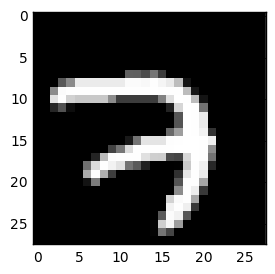

In [7]:
plot(images[0])

In [8]:
labels[0]

7

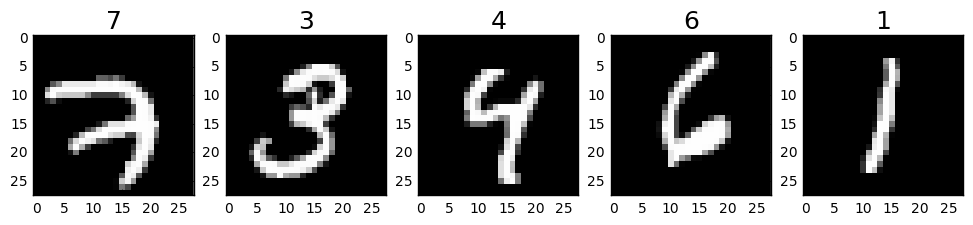

In [9]:
plots(images[:5], titles=labels[:5])

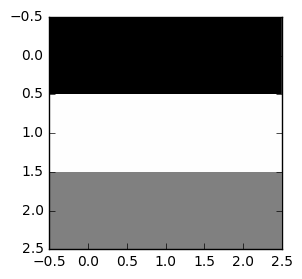

In [10]:
top=[[-1,-1,-1],
     [ 1, 1, 1],
     [ 0, 0, 0]]

plot(top)

This matrix can serve as a top edge filter because for example, for a 3x3 area (black-wigh image), if this area does not include an edge, then it will be something like

[[10, 8, 9] <br>
 [8,  8, 8] <br> 
 [10, 7, 5]] <br>
>Here let's suppose the color code range from (0 to 10) with 10 is the most black.

Then after multiplying the filter, the sum value is -3

If the area includes a top edge, it will be somthing like

[[0, 0, 0] <br>
 [8, 8, 8] <br>
 [9, 7, 5]] <br>
Then after multiplying the filter, the sum value is 24

For the MNIST case, the bachground color is black, so the edge will have a matrix multiplication value -ve and very small.

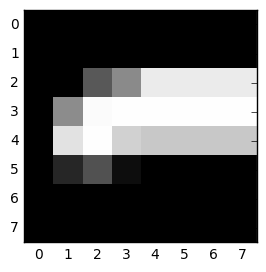

In [11]:
r=(0,28)
def zoomim(x1=0,x2=28,y1=0,y2=28):
    plot(images[0,y1:y2,x1:x2])
w=interactive(zoomim, x1=r,x2=r,y1=r,y2=r)
w

In [17]:
# recommand: x1=1, x2=9, y1=6, y2=14
k=w.kwargs
dims = np.index_exp[k['y1']:k['y2']:1,k['x1']:k['x2']]
images[0][dims]

array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.3529,  0.5412,  0.9216,  0.9216,  0.9216,  0.9216],
       [ 0.    ,  0.549 ,  0.9843,  0.9961,  0.9961,  0.9961,  0.9961,  0.9961],
       [ 0.    ,  0.8863,  0.9961,  0.8157,  0.7804,  0.7804,  0.7804,  0.7804],
       [ 0.    ,  0.149 ,  0.3216,  0.051 ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ]], dtype=float32)

In [18]:
corrtop = correlate(images[0], top)

In [19]:
corrtop[dims]

array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.3529,  0.8941,  1.8157,  2.3843,  2.7647,  2.7647,  2.7647],
       [ 0.549 ,  1.1804,  1.6353,  1.1608,  0.6039,  0.2235,  0.2235,  0.2235],
       [ 0.3373,  0.349 ,  0.1686, -0.3843, -0.6118, -0.6471, -0.6471, -0.8824],
       [-0.7373, -1.4118, -2.1765, -2.2196, -2.3255, -2.3412, -2.3412, -2.1059],
       [-0.149 , -0.4706, -0.5216, -0.3725, -0.051 ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ]], dtype=float32)

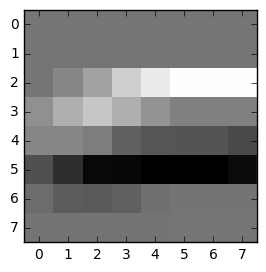

In [20]:
plot(corrtop[dims])

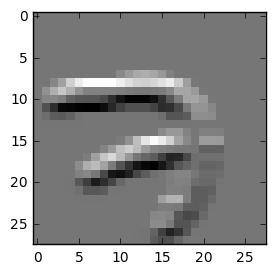

In [21]:
plot(corrtop)

In [22]:
np.rot90(top, 1)

array([[-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0]])

True

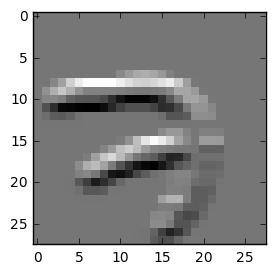

In [23]:
convtop = convolve(images[0], np.rot90(top,2))
plot(convtop)
np.allclose(convtop, corrtop)

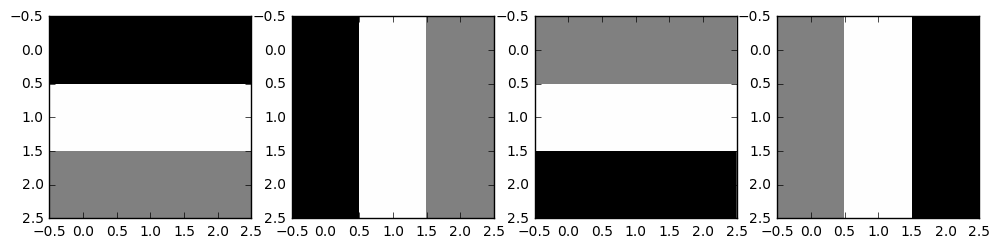

In [24]:
straights=[np.rot90(top,i) for i in range(4)]
plots(straights)

#### How to come out with these filters?

There are some pre-defined filters for certain patterns. But that is not the approach for deep learning. In deep learning, we do not use pre-defined filters, instead, we start with filters with random numbers. 

### Filters in Deep Learning
Now we start with 4 randomly generated filters.

> You can think about convolutions as the weight matrix in the excel example. Actually, that excel example is the simplest, small illustration of convolutions.

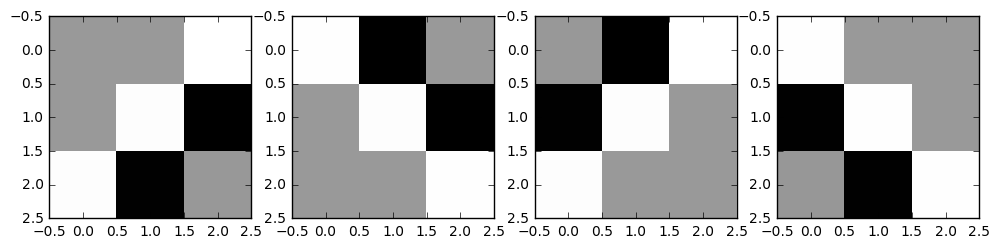

In [26]:
br=[[ 0, 0, 1],
    [ 0, 1,-1.5],
    [ 1,-1.5, 0]]

diags = [np.rot90(br,i) for i in range(4)]
plots(diags)

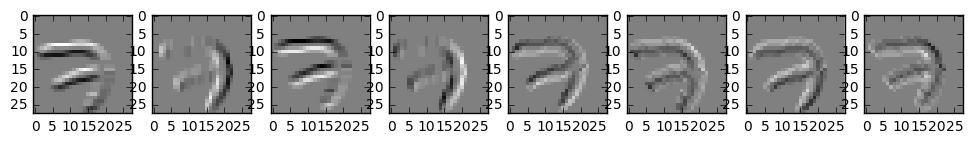

In [28]:
# add the previous 4 filters to get 8 filters for our use
rots = straights + diags
corrs = [correlate(images[0], rot) for rot in rots]
plots(corrs)

### Max Pooling

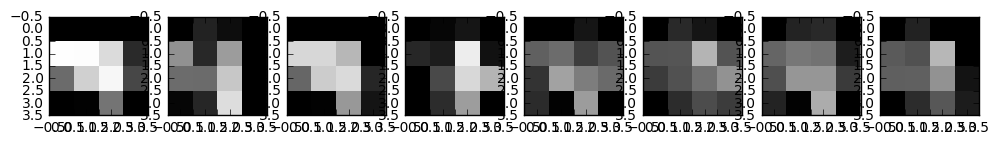

In [29]:
# Maxpooling
def pool(im): return block_reduce(im, (7,7), np.max)

plots([pool(im) for im in corrs])

### Position Invariance

Now, it's a good time to look back at our Vgg model.

In [6]:
from vgg16 import Vgg16
vgg = Vgg16()
vgg.model.summary()

Using Theano backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

We know that the filters are position invariant. That means, the filters are able to pick up the pattern wherever it is inside the picture.

However, we need to be able to identify position to some extent, because if there are 4 eyes in the picture and are far apart, somthing is wrong. So how our deep learning network care about this?

Because it has many layers. As we go down through layers in our model, deeper layers will make sure that there is an eye here, a nose there etc...

### Moving on

In [23]:
eights=[images[i] for i in xrange(n) if labels[i]==8]
ones=[images[i] for i in xrange(n) if labels[i]==1]

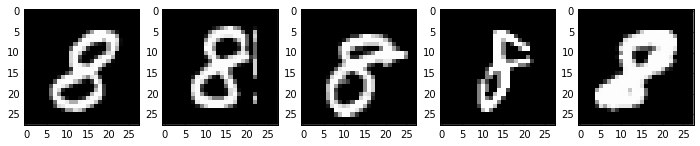

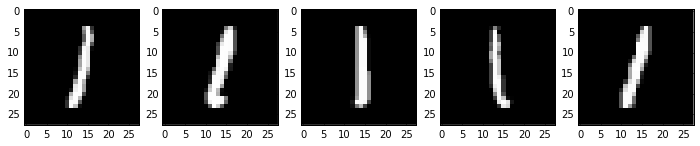

In [24]:
plots(eights[:5])
plots(ones[:5])

In [25]:
pool8 = [np.array([pool(correlate(im, rot)) for im in eights]) for rot in rots]

In [ ]:
len(pool8), pool8[0].shape

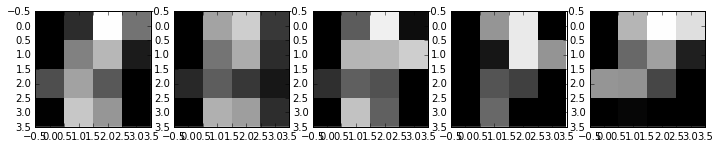

In [26]:
plots(pool8[0][0:5])

In [27]:
def normalize(arr): return (arr-arr.mean())/arr.std()

In [28]:
filts8 = np.array([ims.mean(axis=0) for ims in pool8])
filts8 = normalize(filts8)

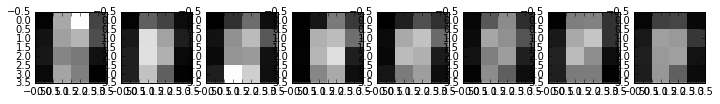

In [29]:
plots(filts8)

In [30]:
pool1 = [np.array([pool(correlate(im, rot)) for im in ones]) for rot in rots]
filts1 = np.array([ims.mean(axis=0) for ims in pool1])
filts1 = normalize(filts1)

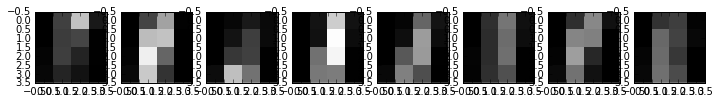

In [31]:
plots(filts1)

In [32]:
def pool_corr(im): return np.array([pool(correlate(im, rot)) for rot in rots])

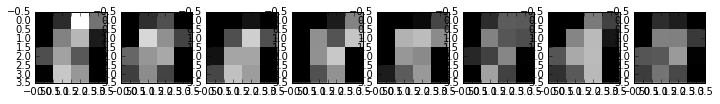

In [33]:
plots(pool_corr(eights[0]))

In [35]:
def sse(a,b): return ((a-b)**2).sum()
def is8_n2(im): return 1 if sse(pool_corr(im),filts1) > sse(pool_corr(im),filts8) else 0

In [36]:
sse(pool_corr(eights[0]), filts8), sse(pool_corr(eights[0]), filts1)

(126.77776, 181.26105)

In [37]:
[np.array([is8_n2(im) for im in ims]).sum() for ims in [eights,ones]]

[5223, 287]

In [38]:
[np.array([(1-is8_n2(im)) for im in ims]).sum() for ims in [eights,ones]]

[166, 5892]

In [ ]:
def n1(a,b): return (np.fabs(a-b)).sum()
def is8_n1(im): return 1 if n1(pool_corr(im),filts1) > n1(pool_corr(im),filts8) else 0

In [ ]:
[np.array([is8_n1(im) for im in ims]).sum() for ims in [eights,ones]]

In [ ]:
[np.array([(1-is8_n1(im)) for im in ims]).sum() for ims in [eights,ones]]